In [1]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRFRegressor
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

## Connect Cassandra - Python :

In [2]:
cluster = Cluster()

session = cluster.connect('cryptocurrency')

In [3]:
query = "SELECT * FROM currencies ;"

complete_df = pd.DataFrame(list(session.execute(query)))

complete_df

,symbol,date_time,close,high,low,marketcap,open,volume
0,LTC,2013-04-30 05:29:59,4.383900,4.573600,4.225640,7.538896e+07,4.366760,0.000000e+00
1,LTC,2013-05-01 05:29:59,4.296490,4.572380,4.168960,7.402092e+07,4.403520,0.000000e+00
2,LTC,2013-05-02 05:29:59,3.801010,4.356860,3.520290,6.560460e+07,4.289540,0.000000e+00
3,LTC,2013-05-03 05:29:59,3.371980,4.039300,3.007170,5.828798e+07,3.780020,0.000000e+00
4,LTC,2013-05-04 05:29:59,3.044910,3.453610,2.395940,5.269485e+07,3.390440,0.000000e+00
...,...,...,...,...,...,...,...,...
18919,DOGE,2021-07-03 05:29:59,0.245264,0.247997,0.238848,3.194925e+10,0.243982,1.321471e+09
18920,DOGE,2021-07-04 05:29:59,0.246411,0.250214,0.242454,3.210491e+10,0.245106,9.170158e+08
18921,DOGE,2021-07-05 05:29:59,0.246483,0.252567,0.243425,3.211767e+10,0.246425,9.735115e+08
18922,DOGE,2021-07-06 05:29:59,0.231614,0.246419,0.227838,3.018344e+10,0.246419,1.267949e+09


###  Currency :

In [4]:
print("-----CRYPTOCURRENCIES-------")
print("1. Bitcoin \n2. Dogecoin \n3. Ethereum \n4. Litecoin \n5. Monero \n6. Steller \n7. XRP")
currency_list = ['BTC', 'DOGE', 'ETH', 'LTC', 'XMR', 'XLM', 'XRP']


-----CRYPTOCURRENCIES-------
1. Bitcoin 
2. Dogecoin 
3. Ethereum 
4. Litecoin 
5. Monero 
6. Steller 
7. XRP


In [5]:
currency_dir = {}
for i in currency_list  :
    
    query = "SELECT * FROM currencies WHERE symbol= %s;"
    globals()['df_%s' % i] = pd.DataFrame(list(session.execute(query, [i])))
    
    ke = i
    val = globals()['df_%s' % i]
    
    currency_dir[ke] = val


## DATA PRE - PROCESSING

### 1 . IMPUTING NA VALUES AS MEAN

In [6]:
def impute_Na (df) :
    
    df.loc[df['close'].isnull(),'close'] = df['close'].rolling(5, min_periods=1, center=True).mean()
    df.loc[df['high'].isnull(),'high'] = df['high'].rolling(5, min_periods=1, center=True).mean()
    df.loc[df['low'].isnull(),'low'] = df['low'].rolling(5, min_periods=1, center=True).mean()
    df.loc[df['open'].isnull(),'open'] = df['open'].rolling(5, min_periods=1, center=True).mean()
    df.loc[df['marketcap'].isnull(),'marketcap'] = df['marketcap'].rolling(5, min_periods=1, center=True).mean()

 

In [7]:
# Graphical representation of null values
def null_graph(df) :
    plt.figure(figsize=(6,3))
    plt.subplots_adjust(hspace= .2)
    plt.subplot(1,2,1)
    bar=sns.heatmap(df.isnull(),cmap='viridis',yticklabels=False,cbar=False)
    bar.set_title('Showing Null Data')
    bar.set_xlabel('columns',fontsize=15)
    bar.set_ylabel('NaN values',fontsize=15)
    plt.show()
    



### 2. Check for High > Low :

In [8]:

def check_high_low(df) :
    df['high'] = np.where((df['high'] < df['low']), df['low'], df['high'] )


### Plot Graph :

In [9]:
def currency_graph(df) :
    df.plot.line(x = 'date_time',y = 'close')
    plt.xlabel("Time Stamp")
    plt.ylabel("Price in $")
    plt.title("Currency Price ")
    plt.show()


## RSI Model :

In [10]:
def rsi(df, period) :
    
    # Take a diff. of values.
    df['gain'] = df['close'].diff()
    df['loss'] = df['close'].diff()
    
    # Replacing negative/positive with '0' in Gain/Loss respectively.
    df.loc[df["gain"] < 0, 'gain' ] = 0
    df.loc[df["loss"] > 0, 'loss' ] = 0
    
    # Rolling sum by given time period.
    df['avg_gain'] = df['gain'].rolling(period).sum()
    df['avg_loss'] = abs(df['loss'].rolling(period).sum())
    
    # Relative strangth ratio.
    df['rs'] = (df['avg_gain']/period)/(df['avg_loss']/period)
    
    # Calculating RSI value
    df['RSI'] = 100 - (100/(1+df['rs']))
    df['high_rsi'] = 80
    df['low_rsi'] = 20


### Ploting RSI Model :

In [11]:
def plot_rsi(df) :
    
    fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True, )
    
    fig.add_trace(go.Candlestick(x= df['date_time'],
                                 open  = df['open'], high  = df['high'],
                                 low   = df['low'], close = df['close'],
                                 showlegend =False ),
                  row=1, col=1)
        
    fig.add_trace(go.Scatter(x=df['date_time'], y=df['RSI'],
                             mode='lines', showlegend =False,
                             line=dict(color="red", width=2)),
                  row=2, col=1)
    
    fig.add_trace(go.Scatter(x=df['date_time'], y = df['low_rsi'],
                              fill='tonexty', mode='lines',
                              showlegend =False,
                              line=dict(width=2, color='lightblue', dash='dash')),
                  row=2, col=1)
        
    fig.add_trace(go.Scatter(x=df['date_time'], y = df['high_rsi'],
                             fill='tonexty', mode='lines',
                             showlegend =False,
                             line=dict(width=2, color='lightblue', dash='dash')),
                  row=2, col=1)
    
    fig.show()


## MACD Model :

In [12]:
def macd(df) : 
    df['12 day ema'] = df['close'].ewm(span=12).mean()
    df['26 day ema'] = df['close'].ewm(span=26).mean()
    df['MACD'] = df['12 day ema'] - df['26 day ema']
    df['9 day ema'] = df['MACD'].ewm(span=9).mean()


### Plot MACD Model :

In [13]:
def plot_macd(df) :
    
    fig = px.line(df, x="date_time", y="MACD", title = "MACD Indicator")
    fig.add_scatter(x=df['date_time'], y=df['9 day ema'], mode='lines')
    fig.show()


## Bollinger Bands :

In [14]:
def bb(df) :
    df['20 day sma'] = df['close'].rolling(20).mean()
    df['+2 sd'] = df['20 day sma'] + (2* df['close'].rolling(20).std())
    df['-2 sd'] = df['20 day sma'] - (2* df['close'].rolling(20).std())    


### Plot BB :

In [15]:
def plot_bb(df) :
    
    fig = make_subplots(rows=1, cols=1,
                    shared_xaxes=True, )
        
    fig.add_trace(go.Scatter(x=df['date_time'], y=df['close'],
                             mode='lines', showlegend =False, name= 'Close Price',
                             line=dict(color="red", width=2)),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df['date_time'], y = df['+2 sd'],
                              fill='tonexty', mode='lines+markers', name= '+2 SD',
                              showlegend =False,
                              line=dict(width=1, color='lightblue', dash='dash')),
                  row=1, col=1)
       
    fig.add_trace(go.Scatter(x=df['date_time'], y=df['20 day sma'],
                             mode='lines', showlegend =False, name= '20 Day SMA',
                             line=dict(color="black", width=1)),
                  row=1, col=1)
    
    fig.add_trace(go.Scatter(x=df['date_time'], y = df['-2 sd'],
                              fill='tonexty', mode='lines+markers', name= '-2 SD',
                              showlegend =False,
                              line=dict(width=1, color='lightblue', dash='dash')),
                  row=1, col=1)
    
    
    fig.show()


### Show Null Values of all currencies :

Analytics for : BTC
BTC Null Value Graph : 


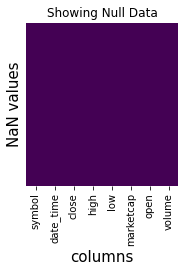

Analytics for : DOGE
DOGE Null Value Graph : 


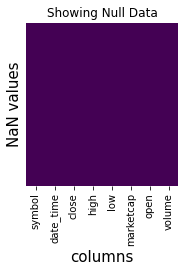

Analytics for : ETH
ETH Null Value Graph : 


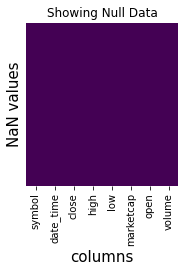

Analytics for : LTC
LTC Null Value Graph : 


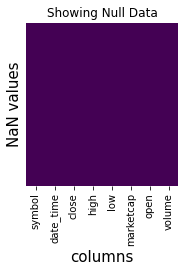

Analytics for : XMR
XMR Null Value Graph : 


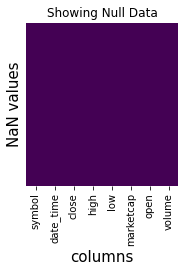

Analytics for : XLM
XLM Null Value Graph : 


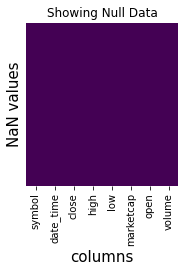

Analytics for : XRP
XRP Null Value Graph : 


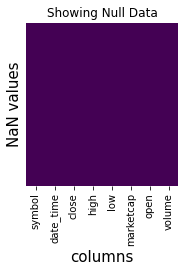

In [16]:
for ke, val in currency_dir.items() :
    
    print(f"Analytics for : {ke}")
    # Data Pre-processing :
    impute_Na(val)
    check_high_low(val)
    
    # Plotting currency graph :
    print(f"{ke} Null Value Graph : ")
    null_graph(val)
    
    
    
    
   

## Imply indicators on selected  currency :

In [18]:
print("-----CRYPTOCURRENCIES-------")
print("1. Bitcoin \n2. Dogecoin \n3. Ethereum \n4. Litecoin \n5. Monero \n6. Steller \n7. XRP")

choice = int(input("Enter Your Choice For Currencies : "))

if choice == 1 :
    print(f"Analytics for : BTC")
    df = currency_dir["BTC"]

elif choice == 2 :
    print(f"Analytics for : DOGE")
    df = currency_dir["DOGE"]

elif choice == 3 :
    print(f"Analytics for : ETH")
    df = currency_dir["ETH"]

elif choice == 4 :
    print(f"Analytics for : LTC")
    df = currency_dir["LTC"]

elif choice == 5 :
    print(f"Analytics for : XMR")
    df = currency_dir["XMR"]

elif choice == 6 :
    print(f"Analytics for : XLM")
    df = currency_dir["XLM"]

elif choice == 7 :
    print(f"Analytics for : XRP")
    df = currency_dir["XRP"]

else :
    print("Enter Correct Input !!! ")
    

# Data Pre-processing :
impute_Na(df)
check_high_low(df)
df = df.fillna(0)
df1 = df.iloc[-400:]

# Plotting currency graph :
# RSI Indicator :
period = 14
rsi(df1, period)
# Plotting  RSI Indicator :
print("RSI Indicator with Closing Price : ")
plot_rsi(df1)
    
# MACD Indicator :
macd(df1)
# Plotting MACD Indicator :
plot_macd(df1)
    
# BB Indicator :
bb(df1)
# Plotting BB Indicator 
print("Bollinger Band : ")
plot_bb(df1)


-----CRYPTOCURRENCIES-------
1. Bitcoin 
2. Dogecoin 
3. Ethereum 
4. Litecoin 
5. Monero 
6. Steller 
7. XRP
Enter Your Choice For Currencies : 1
Analytics for : BTC
RSI Indicator with Closing Price : 


Bollinger Band : 


### Splitting the date : 

In [19]:
df['Date_year'] = df["date_time"].dt.year
df['Date_month'] = df["date_time"].dt.month
df['Date_day'] = df["date_time"].dt.day

In [20]:
df

,symbol,date_time,close,high,low,marketcap,open,volume,Date_year,Date_month,Date_day
0,BTC,2013-04-30 05:29:59,144.539993,147.488007,134.000000,1.603769e+09,134.444000,0.000000e+00,2013,4,30
1,BTC,2013-05-01 05:29:59,139.000000,146.929993,134.050003,1.542813e+09,144.000000,0.000000e+00,2013,5,1
2,BTC,2013-05-02 05:29:59,116.989998,139.889999,107.720001,1.298955e+09,139.000000,0.000000e+00,2013,5,2
3,BTC,2013-05-03 05:29:59,105.209999,125.599998,92.281898,1.168517e+09,116.379997,0.000000e+00,2013,5,3
4,BTC,2013-05-04 05:29:59,97.750000,108.127998,79.099998,1.085995e+09,106.250000,0.000000e+00,2013,5,4
...,...,...,...,...,...,...,...,...,...,...,...
2986,BTC,2021-07-03 05:29:59,33897.048590,33939.588699,32770.680780,6.354508e+11,33549.600177,3.872897e+10,2021,7,3
2987,BTC,2021-07-04 05:29:59,34668.548402,34909.259899,33402.696536,6.499397e+11,33854.421362,2.438396e+10,2021,7,4
2988,BTC,2021-07-05 05:29:59,35287.779766,35937.567147,34396.477458,6.615748e+11,34665.564866,2.492431e+10,2021,7,5
2989,BTC,2021-07-06 05:29:59,33746.002456,35284.344430,33213.661034,6.326962e+11,35284.344430,2.672155e+10,2021,7,6


In [21]:
df.drop(['date_time', 'symbol'], axis=1, inplace=True)
df = df.fillna(0)
df.head()

,close,high,low,marketcap,open,volume,Date_year,Date_month,Date_day
0,144.539993,147.488007,134.000000,1.603769e+09,134.444000,0.0,2013,4,30
1,139.000000,146.929993,134.050003,1.542813e+09,144.000000,0.0,2013,5,1
2,116.989998,139.889999,107.720001,1.298955e+09,139.000000,0.0,2013,5,2
3,105.209999,125.599998,92.281898,1.168517e+09,116.379997,0.0,2013,5,3
4,97.750000,108.127998,79.099998,1.085995e+09,106.250000,0.0,2013,5,4


### UNDERSTANDING CORRELATION BETWEEN COLUMNS


In [22]:
df.corr()

,close,high,low,marketcap,open,volume,Date_year,Date_month,Date_day
close,1.000000,0.999417,0.999291,0.999709,0.998646,0.807388,0.677122,-0.140870,-0.009679
high,0.999417,1.000000,0.998841,0.999094,0.999442,0.810464,0.675306,-0.142182,-0.007945
low,0.999291,0.998841,1.000000,0.999072,0.998905,0.803110,0.679419,-0.139139,-0.010021
marketcap,0.999709,0.999094,0.999072,1.000000,0.998382,0.809156,0.672979,-0.141684,-0.009596
open,0.998646,0.999442,0.998905,0.998382,1.000000,0.808439,0.676702,-0.141251,-0.008113
volume,0.807388,0.810464,0.803110,0.809156,0.808439,1.000000,0.727060,-0.154816,0.009895
Date_year,0.677122,0.675306,0.679419,0.672979,0.676702,0.727060,1.000000,-0.168048,-0.008576
Date_month,-0.140870,-0.142182,-0.139139,-0.141684,-0.141251,-0.154816,-0.168048,1.000000,0.009421
Date_day,-0.009679,-0.007945,-0.010021,-0.009596,-0.008113,0.009895,-0.008576,0.009421,1.000000


<AxesSubplot:>

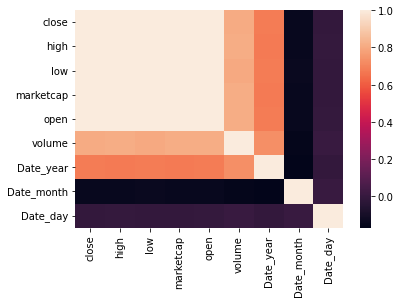

In [23]:
sns.heatmap(df.corr())

### Outlier

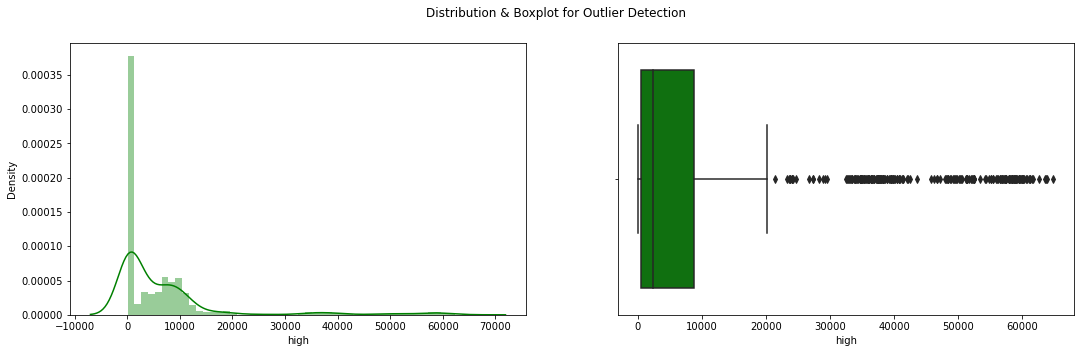

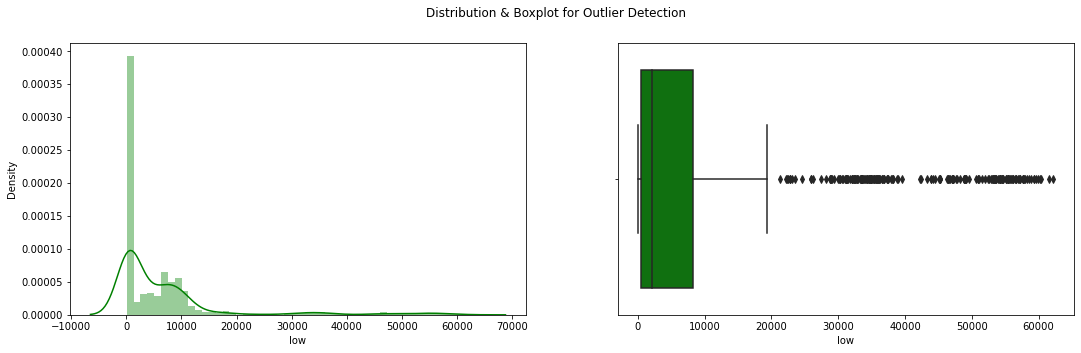

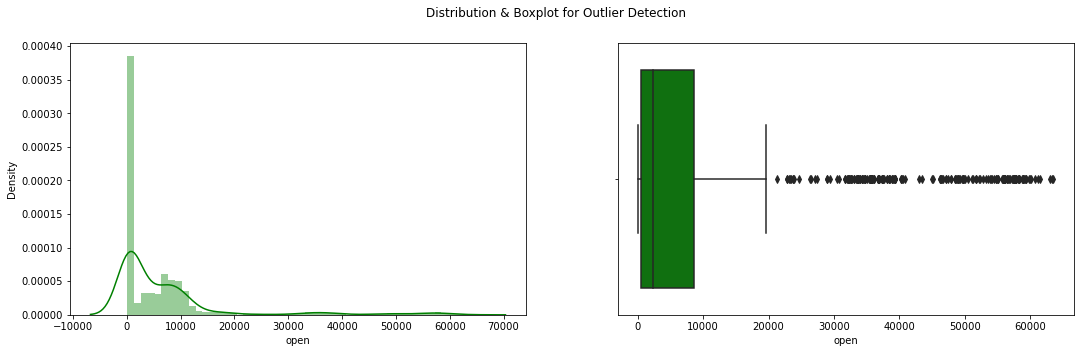

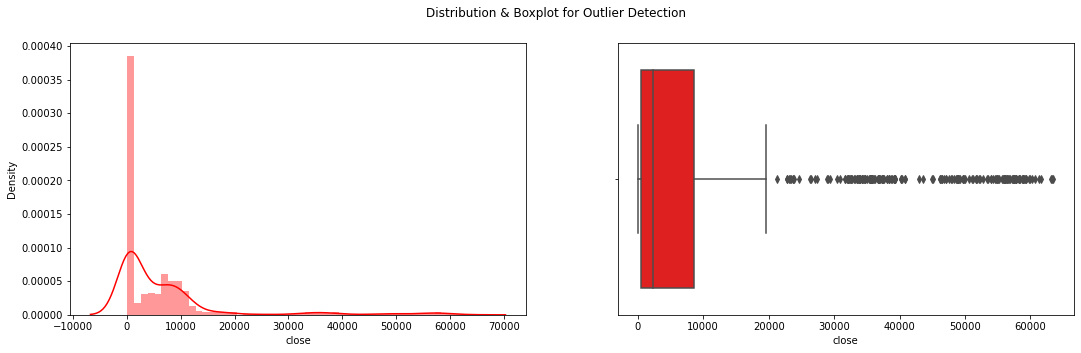

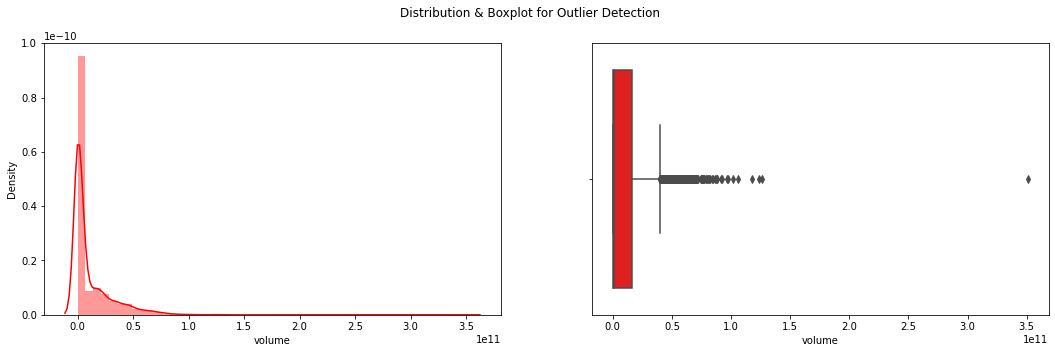

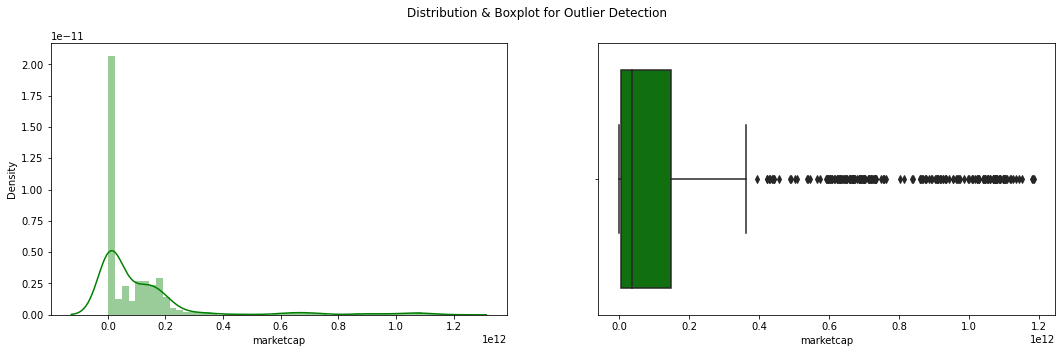

In [24]:
numeric=['high', 'low', 'open','close','volume', 'marketcap']
cols=['Name', 'Symbol']

def outlier(cols):
    color = random.choice(['r', 'g', 'b'])
    fig, ax = plt.subplots(1,2,figsize=(18,5))
    sns.distplot(cols, ax=ax[0], color=color)
    sns.boxplot(cols, ax=ax[1], color=color)
    plt.suptitle('Distribution & Boxplot for Outlier Detection')
    fig.show()
    return None


for i in numeric:
    outlier(df[i])


### FEATURE SCALING

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [26]:
scaler.fit(df)
dfscaled=scaler.transform(df)


In [27]:
df_scaled = pd.DataFrame(dfscaled,columns=df.columns, index=df.index)

df_scaled

,close,high,low,marketcap,open,volume,Date_year,Date_month,Date_day
0,-0.581321,-0.579495,-0.584511,-0.565517,-0.581748,-0.577489,-1.638045,-0.733142,1.622102
1,-0.581812,-0.579543,-0.584507,-0.565806,-0.580902,-0.577489,-1.638045,-0.440140,-1.669192
2,-0.583760,-0.580148,-0.586930,-0.566962,-0.581345,-0.577489,-1.638045,-0.440140,-1.555699
3,-0.584803,-0.581376,-0.588350,-0.567580,-0.583349,-0.577489,-1.638045,-0.440140,-1.442206
4,-0.585463,-0.582876,-0.589563,-0.567972,-0.584246,-0.577489,-1.638045,-0.440140,-1.328713
...,...,...,...,...,...,...,...,...,...
2986,2.406617,2.323385,2.418713,2.439800,2.378972,1.473205,1.702260,0.145864,-1.442206
2987,2.474914,2.406684,2.476871,2.508498,2.405981,0.713638,1.702260,0.145864,-1.328713
2988,2.529732,2.495020,2.568318,2.563664,2.477851,0.742250,1.702260,0.145864,-1.215220
2989,2.393246,2.438905,2.459476,2.426739,2.532678,0.837414,1.702260,0.145864,-1.101727


### SPLITTING DATASET INTO TRAINING ND TEST SET

In [28]:
x=df_scaled.drop(["close"], axis=1)
y=df["close"].astype(int)


In [29]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2)


In [30]:
# from sklearn.model_selection import train_test_split
# xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3)

In [31]:
models_dir = { }

## MODELLING THROUGH ML TECHNIQUES


## REGRESSION

###  LINEAR REGRESSION 

In [32]:
regressor = LinearRegression()
kfold = KFold(n_splits=5, random_state=2020,shuffle=True)
results = cross_val_score(regressor, x, y, cv=kfold, 
                          scoring='r2')
R2 = results
linear_lst= []

linear_best_model = regressor
print(f"Best Peramater is : {linear_best_model}" )

linear_r2 = R2.mean()
print(f"R2 Score is : {linear_r2}")

linear_lst.extend([linear_best_model, linear_r2])


Best Peramater is : LinearRegression()
R2 Score is : 0.9997468389965516


In [33]:
models_dir["linear_regg"] = linear_lst
models_dir


{'linear_regg': [LinearRegression(), 0.9997468389965516]}

### LASSO REGRESSION


In [34]:
parameters = dict(alpha=np.linspace(0.001,5))
Ls = Lasso()

kfold = KFold(n_splits=5, random_state=2021, shuffle = True)

cv = GridSearchCV(Ls, param_grid=parameters, cv=kfold, scoring='r2')

cv.fit(xtrain,ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-03, 1.03020408e-01, 2.05040816e-01, 3.07061224e-01,
       4.09081633e-01, 5.11102041e-01, 6.13122449e-01, 7.15142857e-01,
       8.17163265e-01, 9.19183673e-01, 1.02120408e+00, 1.12322449e+00,
       1.22524490e+00, 1.32726531e+00, 1.42928571e+00, 1.53130612e+00,...
       2.44948980e+00, 2.55151020e+00, 2.65353061e+00, 2.75555102e+00,
       2.85757143e+00, 2.95959184e+00, 3.06161224e+00, 3.16363265e+00,
       3.26565306e+00, 3.36767347e+00, 3.46969388e+00, 3.57171429e+00,
       3.67373469e+00, 3.77575510e+00, 3.87777551e+00, 3.97979592e+00,
       4.08181633e+00, 4.18383673e+00, 4.28585714e+00, 4.38787755e+00,
       4.48989796e+00, 4.59191837e+00, 4.69393878e+00, 4.79595918e+00,
       4.89797959e+00, 5.00000000e+00])},
             scoring='r2')

In [35]:
ypred = cv.predict(xtest)

In [36]:
lasso_lst= []

lasso_best_model = cv.best_estimator_
print(f"Best Peramater is : {lasso_best_model}" )

lasso_r2 = cv.best_score_
print(f"R2 Score is : {lasso_r2}")

lasso_lst.extend([lasso_best_model, lasso_r2])


Best Peramater is : Lasso(alpha=1.8373673469387752)
R2 Score is : 0.9996889357827952


In [37]:
models_dir["lasso_regg"] = lasso_lst
models_dir

{'linear_regg': [LinearRegression(), 0.9997468389965516],
 'lasso_regg': [Lasso(alpha=1.8373673469387752), 0.9996889357827952]}

### Ridge Regression

In [38]:
parameters = dict(alpha=np.linspace(0.001,40,25))

Rg = Ridge()

cv = GridSearchCV(Rg, param_grid=parameters, cv=kfold,scoring='r2')

cv.fit(xtrain, ytrain) 

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': array([1.0000000e-03, 1.6676250e+00, 3.3342500e+00, 5.0008750e+00,
       6.6675000e+00, 8.3341250e+00, 1.0000750e+01, 1.1667375e+01,
       1.3334000e+01, 1.5000625e+01, 1.6667250e+01, 1.8333875e+01,
       2.0000500e+01, 2.1667125e+01, 2.3333750e+01, 2.5000375e+01,
       2.6667000e+01, 2.8333625e+01, 3.0000250e+01, 3.1666875e+01,
       3.3333500e+01, 3.5000125e+01, 3.6666750e+01, 3.8333375e+01,
       4.0000000e+01])},
             scoring='r2')

In [39]:
y_pred = cv.predict(xtest)

In [40]:
ridge_lst= []

ridge_best_model = cv.best_estimator_
print(f"Best Peramater is : {ridge_best_model}" )

ridge_r2 = cv.best_score_
print(f"R2 Score is : {ridge_r2}")

ridge_lst.extend([ridge_best_model, ridge_r2])

Best Peramater is : Ridge(alpha=0.001)
R2 Score is : 0.9997642874650923


In [41]:
models_dir["ridge_regg"] = ridge_lst
models_dir

{'linear_regg': [LinearRegression(), 0.9997468389965516],
 'lasso_regg': [Lasso(alpha=1.8373673469387752), 0.9996889357827952],
 'ridge_regg': [Ridge(alpha=0.001), 0.9997642874650923]}

### ElasticNet Regression :

In [42]:
parameters = dict(alpha=np.linspace(0.001,20,5), l1_ratio=np.linspace(0.001,1,10))

El = ElasticNet()

cv = GridSearchCV(El, param_grid=parameters, cv=kfold,scoring='r2')

cv.fit(xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.000000e-03, 5.000750e+00, 1.000050e+01, 1.500025e+01,
       2.000000e+01]),
                         'l1_ratio': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ])},
             scoring='r2')

In [43]:
y_pred = cv.predict(xtest)

In [44]:
elastic_lst= []

elastic_best_model = cv.best_estimator_
print(f"Best Peramater is : {elastic_best_model}" )

elastic_r2 = cv.best_score_
print(f"R2 Score is : {elastic_r2}")

elastic_lst.extend([elastic_best_model, elastic_r2])

Best Peramater is : ElasticNet(alpha=0.001, l1_ratio=0.556)
R2 Score is : 0.9997381640747927


In [45]:
models_dir["elastic_regg"] = elastic_lst
models_dir

{'linear_regg': [LinearRegression(), 0.9997468389965516],
 'lasso_regg': [Lasso(alpha=1.8373673469387752), 0.9996889357827952],
 'ridge_regg': [Ridge(alpha=0.001), 0.9997642874650923],
 'elastic_regg': [ElasticNet(alpha=0.001, l1_ratio=0.556), 0.9997381640747927]}

### Random Forest :

In [46]:
depth_range = [3,4,5,6,7,8,9]
minsplit_range = [5,10,20,25,30]
minleaf_range = [5,10,15]

parameters = dict(max_depth=depth_range,
                  min_samples_split=minsplit_range, 
                  min_samples_leaf=minleaf_range)

kfold = KFold(n_splits=5, random_state=2021,shuffle=True)

dtr = DecisionTreeRegressor(random_state=2021)

cv = GridSearchCV(dtr, param_grid=parameters, cv=kfold,scoring='r2')


In [47]:
cv.fit(xtrain,ytrain)

GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=2021),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 20, 25, 30]},
             scoring='r2')

In [48]:
rf_lst = []

rf_best_model = cv.best_estimator_
print(f"Best Peramater is : {rf_best_model}" )

rf_r2 = cv.best_score_
print(f"R2 Score is : {rf_r2}")

rf_lst.extend([rf_best_model, rf_r2])

Best Peramater is : DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=5,
                      random_state=2021)
R2 Score is : 0.9992386765153821


In [49]:
models_dir["random_forest"] = rf_lst
models_dir

{'linear_regg': [LinearRegression(), 0.9997468389965516],
 'lasso_regg': [Lasso(alpha=1.8373673469387752), 0.9996889357827952],
 'ridge_regg': [Ridge(alpha=0.001), 0.9997642874650923],
 'elastic_regg': [ElasticNet(alpha=0.001, l1_ratio=0.556), 0.9997381640747927],
 'random_forest': [DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=5,
                        random_state=2021),
  0.9992386765153821]}

### XG BOOST


In [50]:
parameters = {'learn_rate': [0.01,0.1,0.3,0.5,0.6],
                'max_depth': [25,50],
                'n_estimators': [5,10]}
model_xgb=XGBRFRegressor(random_state=2021)



kfold = KFold(n_splits=5, shuffle=True,random_state=2021)

cv = GridSearchCV(model_xgb, param_grid=parameters,
                  cv=kfold,scoring='r2')

cv.fit(x,y)

xg_lst = []
xg_best_model = cv.best_estimator_
print(f"Best Peramater is : {xg_best_model}" )

xg_r2 = cv.best_score_
print(f"R2 Score is : {xg_r2}")

xg_lst.extend([xg_best_model, xg_r2])



[14:23:53] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:53] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:53] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[14:23:57] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:57] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:58] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[14:24:01] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[14:24:05] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:05] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:05] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[14:24:09] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:09] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:09] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

In [51]:
models_dir["xg_boost"] = xg_lst
models_dir

{'linear_regg': [LinearRegression(), 0.9997468389965516],
 'lasso_regg': [Lasso(alpha=1.8373673469387752), 0.9996889357827952],
 'ridge_regg': [Ridge(alpha=0.001), 0.9997642874650923],
 'elastic_regg': [ElasticNet(alpha=0.001, l1_ratio=0.556), 0.9997381640747927],
 'random_forest': [DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=5,
                        random_state=2021),
  0.9992386765153821],
 'xg_boost': [XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learn_rate=0.01, max_delta_step=0, max_depth=25,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=10, n_jobs=4, num_parallel_tree=10,
                 objective='reg:squarederror', predictor='auto',
                 random_state=2021, reg_alpha=0, scale_pos_weight

### DECISION TREE REGRESSOR

In [52]:
depth_range = [2,6,7,8,9]
minsplit_range = [10,20,25,30,35]
minleaf_range = [15,20]

parameters = dict(max_depth=depth_range,
                  min_samples_split=minsplit_range, 
                  min_samples_leaf=minleaf_range)

kfold = KFold(n_splits=5, random_state=2021,shuffle=True)
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeRegressor(random_state=2021)
cv = GridSearchCV(clf, param_grid=parameters,
                  cv=kfold,scoring='r2')

cv.fit(x,y)

dt_tun_lst = []
 
dtt_best_model = cv.best_estimator_
print(f"Best Peramater is : {dtt_best_model}" )

dtt_r2 = cv.best_score_
print(f"R2 Score is : {dtt_r2}")

dt_tun_lst.extend([rf_best_model, dtt_r2])



Best Peramater is : DecisionTreeRegressor(max_depth=6, min_samples_leaf=15, min_samples_split=10,
                      random_state=2021)
R2 Score is : 0.9979818805819598


In [53]:
models_dir["decision_tree_tunned"] = dt_tun_lst
models_dir

{'linear_regg': [LinearRegression(), 0.9997468389965516],
 'lasso_regg': [Lasso(alpha=1.8373673469387752), 0.9996889357827952],
 'ridge_regg': [Ridge(alpha=0.001), 0.9997642874650923],
 'elastic_regg': [ElasticNet(alpha=0.001, l1_ratio=0.556), 0.9997381640747927],
 'random_forest': [DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=5,
                        random_state=2021),
  0.9992386765153821],
 'xg_boost': [XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
                 importance_type=None, interaction_constraints='',
                 learn_rate=0.01, max_delta_step=0, max_depth=25,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=10, n_jobs=4, num_parallel_tree=10,
                 objective='reg:squarederror', predictor='auto',
                 random_state=2021, reg_alpha=0, scale_pos_weight

### Stack Ensembling :


In [54]:
for key, val in models_dir.items() :
    globals()['%s_model' %key] = val[0]

In [55]:
cv = GradientBoostingRegressor(random_state=2022)

stack = StackingRegressor(estimators=[('Linear',linear_regg_model),
                                      ('Lasso',lasso_regg_model),
                                      ('Ridge',ridge_regg_model),
                                      ('Elastic',elastic_regg_model),
                                      ('Random Forest',random_forest_model),
                                      ('Xg Boost',xg_boost_model),
                                      ('Decission Tree Regressor',decision_tree_tunned_model)],
                          passthrough=True,
                          final_estimator=cv)

stack.fit(xtrain,ytrain)

ypred = stack.predict(xtest)

print(r2_score(ytest, ypred))


[14:24:18] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:19] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:19] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

### COMPARING ALL TECHNIQUES

Best Regression model is : ridge_regg
Best Score is : 0.9997642874650923


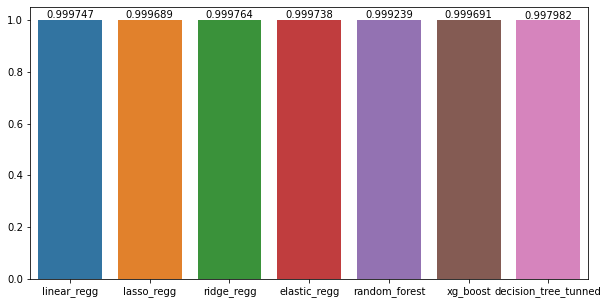

In [56]:
models = list(models_dir.keys())
values = list(models_dir.values())
score_lst = [] 
for i in range(len(values)) :
    score_lst.append(values[i][1])

fig, ax = plt.subplots()
    
fig.set_size_inches(10,5)
    
ax = sns.barplot(x= models, y=score_lst , )
for i in ax.containers:
    ax.bar_label(i,)


best_score = max(score_lst)
best_model = models[score_lst.index(best_score)]

print("Best Regression model is :", best_model)
print("Best Score is :", best_score)
